In [23]:

import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import  OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from tqdm import tqdm


# Download latest version of the dataset and save the path in which it was downloaded to
path = kagglehub.dataset_download("fedesoriano/heart-failure-prediction")  



In [24]:
#Read in the heart data
heart_data = pd.read_csv(f"{path}/heart.csv")

heart_data.head()


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [25]:
#First the one hot encoder needs to be applied to the columns
#ChestPainType, RestingECG, ST_Slope
to_encode = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]
new_encoder = OneHotEncoder( sparse_output=False)
encoded_heart = new_encoder.fit_transform(heart_data[to_encode])
encoded_heart = pd.DataFrame(encoded_heart, columns=new_encoder.get_feature_names_out(to_encode), index=heart_data.index)
print(encoded_heart)

heart_data = pd.concat([heart_data, encoded_heart], axis=1)
heart_data = heart_data.drop(columns=to_encode)
#As a sanity check to make sure all values are numeric
heart_data = heart_data.astype(float)
heart_data.head()


     Sex_F  Sex_M  ChestPainType_ASY  ChestPainType_ATA  ChestPainType_NAP  \
0      0.0    1.0                0.0                1.0                0.0   
1      1.0    0.0                0.0                0.0                1.0   
2      0.0    1.0                0.0                1.0                0.0   
3      1.0    0.0                1.0                0.0                0.0   
4      0.0    1.0                0.0                0.0                1.0   
..     ...    ...                ...                ...                ...   
913    0.0    1.0                0.0                0.0                0.0   
914    0.0    1.0                1.0                0.0                0.0   
915    0.0    1.0                1.0                0.0                0.0   
916    1.0    0.0                0.0                1.0                0.0   
917    0.0    1.0                0.0                0.0                1.0   

     ChestPainType_TA  RestingECG_LVH  RestingECG_Normal  Resti

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40.0,140.0,289.0,0.0,172.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,49.0,160.0,180.0,0.0,156.0,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,37.0,130.0,283.0,0.0,98.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,48.0,138.0,214.0,0.0,108.0,1.5,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,54.0,150.0,195.0,0.0,122.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [26]:
#Next the training changed_parameter need to be made
target = heart_data['HeartDisease']
x_data = heart_data.drop(columns="HeartDisease")

x_train, x_test, y_train, y_test = train_test_split(x_data, target)


In [27]:
#Now apply the standard scaler to the x_train data

scaler = MinMaxScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

100%|██████████| 19/19 [00:00<00:00, 231.65it/s]


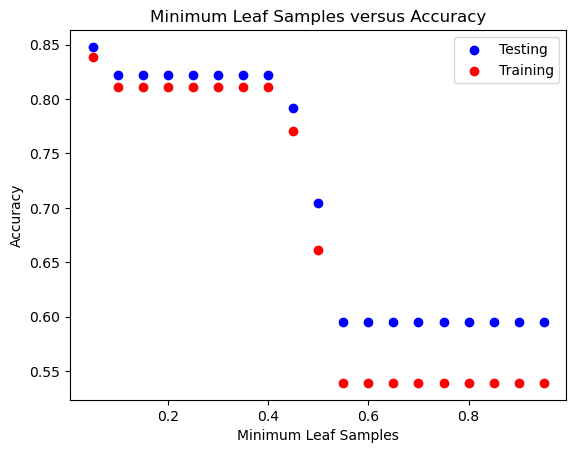

100%|██████████| 19/19 [00:00<00:00, 260.22it/s]


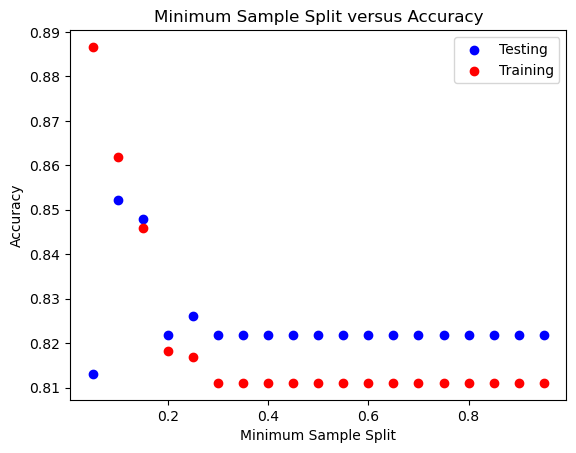

In [28]:

#These variables are used to store the parameter being changed to improve fit as well as the accuracy scores for training and testing
changed_parameter = []
training_scores = []
testing_scores = []


#A for loop is used to fit the classifier to the scaled data
#the tqdm package is used to estimate timing and to prevent the user from accidentally selecting too many parameters to change in the range
for n_est in tqdm(np.arange(0.05, 1.0, 0.05)):
        classy = DecisionTreeClassifier(min_samples_leaf=n_est)
        changed_parameter.append(n_est)
        classy.fit(x_train_scaled, y_train)
        testing_scores.append(classy.score(x_test_scaled, y_test))
        training_scores.append(classy.score(x_train_scaled, y_train))
        y_pred_train = classy.predict(x_train_scaled)
        y_pred_test = classy.predict(x_test_scaled)

#To get a general sense of where accuracy is improving, a matplotlib graph is used
#This also helps to narrow down or widen a range to use to optimize the best performing classifier later
fig, ax = plt.subplots()
ax.scatter(changed_parameter, testing_scores, c="blue", label="Testing")
ax.scatter(changed_parameter, training_scores, c="red", label="Training")
ax.legend()
X_text = "Minimum Leaf Samples"
plt.title(f"{X_text} versus Accuracy")
plt.xlabel(X_text)
plt.ylabel("Accuracy")
plt.show()


#The for loop above is repeated for each classifier
changed_parameter = []
training_scores = []
testing_scores = []

for n_est in tqdm(np.arange(0.05, 1.0, 0.05)):
        classy = DecisionTreeClassifier(min_samples_split=n_est)
        changed_parameter.append(n_est)
        classy.fit(x_train_scaled, y_train)
        testing_scores.append(classy.score(x_test_scaled, y_test))
        training_scores.append(classy.score(x_train_scaled, y_train))
        y_pred_train = classy.predict(x_train_scaled)
        y_pred_test = classy.predict(x_test_scaled)
      
fig, ax = plt.subplots()
ax.scatter(changed_parameter, testing_scores, c="blue", label="Testing")
ax.scatter(changed_parameter, training_scores, c="red", label="Training")
ax.legend()
X_text = "Minimum Sample Split"
plt.title(f"{X_text} versus Accuracy")
plt.xlabel(X_text)
plt.ylabel("Accuracy")
plt.show()


100%|██████████| 99/99 [01:30<00:00,  1.09it/s]


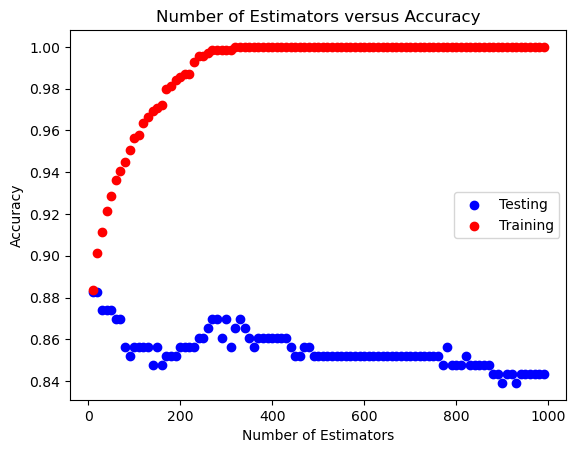

100%|██████████| 19/19 [00:00<00:00, 40.33it/s]


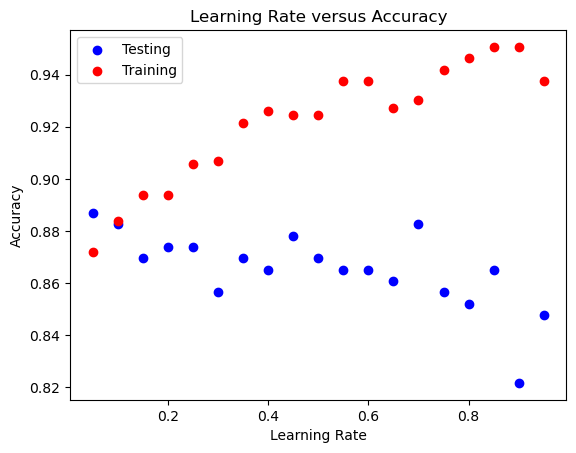

100%|██████████| 8/8 [00:00<00:00, 41.66it/s]


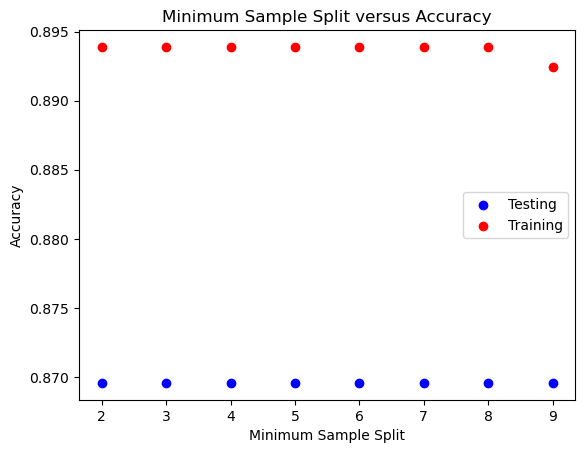

100%|██████████| 9/9 [00:00<00:00, 59.99it/s]


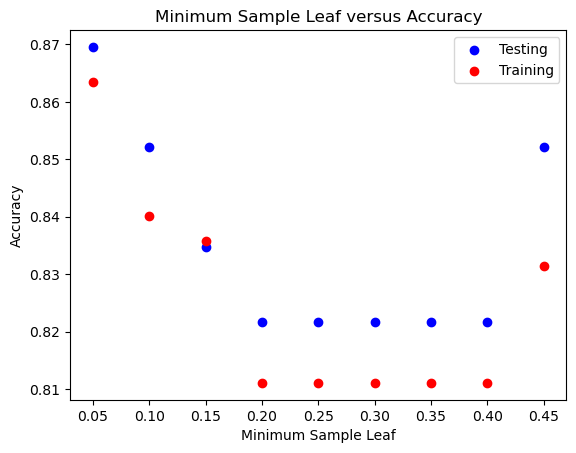

In [53]:


changed_parameter = []
training_scores = []
testing_scores = []



for n_est in tqdm(range(10, 1000, 10)):
        classy = GradientBoostingClassifier(n_estimators=n_est)
        changed_parameter.append(int(n_est))
        classy.fit(x_train_scaled, y_train)
        testing_scores.append(classy.score(x_test_scaled, y_test))
        training_scores.append(classy.score(x_train_scaled, y_train))
        y_pred_train = classy.predict(x_train_scaled)
        y_pred_test = classy.predict(x_test_scaled)
   
X_text = "Number of Estimators"
fig, ax = plt.subplots()
ax.scatter(changed_parameter, testing_scores, c="blue", label="Testing")
ax.scatter(changed_parameter, training_scores, c="red", label="Training")
ax.legend()
Y_text = "Accuracy"
plt.title(f"{X_text} versus {Y_text}")
plt.xlabel(X_text)
plt.ylabel(Y_text)
plt.show()


changed_parameter = []
training_scores = []
testing_scores = []



for lern in tqdm(np.arange(0.05, 1.0, 0.05)):
        classy = GradientBoostingClassifier(n_estimators=10, learning_rate=lern)
        changed_parameter.append(lern)
        classy.fit(x_train_scaled, y_train)
        testing_scores.append(classy.score(x_test_scaled, y_test))
        training_scores.append(classy.score(x_train_scaled, y_train))
        y_pred_train = classy.predict(x_train_scaled)
        y_pred_test = classy.predict(x_test_scaled)

        
X_text = "Learning Rate"
fig, ax = plt.subplots()
ax.scatter(changed_parameter, testing_scores, c="blue", label="Testing")
ax.scatter(changed_parameter, training_scores, c="red", label="Training")
ax.legend()
Y_text = "Accuracy"
plt.title(f"{X_text} versus {Y_text}")
plt.xlabel(X_text)
plt.ylabel(Y_text)
plt.show()





changed_parameter = []
training_scores = []
testing_scores = []



for split in tqdm(range(2, 10)):
        classy = GradientBoostingClassifier(n_estimators=10, learning_rate=0.15, min_samples_split=split)
        changed_parameter.append(split)
        classy.fit(x_train_scaled, y_train)
        testing_scores.append(classy.score(x_test_scaled, y_test))
        training_scores.append(classy.score(x_train_scaled, y_train))
        y_pred_train = classy.predict(x_train_scaled)
        y_pred_test = classy.predict(x_test_scaled)

        
X_text = "Minimum Sample Split"
fig, ax = plt.subplots()
ax.scatter(changed_parameter, testing_scores, c="blue", label="Testing")
ax.scatter(changed_parameter, training_scores, c="red", label="Training")
ax.legend()
Y_text = "Accuracy"
plt.title(f"{X_text} versus {Y_text}")
plt.xlabel(X_text)
plt.ylabel(Y_text)
plt.show()



changed_parameter = []
training_scores = []
testing_scores = []


for lern in tqdm(np.arange(0.05, 0.5, 0.05)):
        classy = GradientBoostingClassifier(n_estimators=10, min_samples_leaf=lern)
        changed_parameter.append(lern)
        classy.fit(x_train_scaled, y_train)
        testing_scores.append(classy.score(x_test_scaled, y_test))
        training_scores.append(classy.score(x_train_scaled, y_train))
        y_pred_train = classy.predict(x_train_scaled)
        y_pred_test = classy.predict(x_test_scaled)
      
        
fig, ax = plt.subplots()
ax.scatter(changed_parameter, testing_scores, c="blue", label="Testing")
ax.scatter(changed_parameter, training_scores, c="red", label="Training")
ax.legend()
X_text = "Minimum Sample Leaf"
plt.title(f"{X_text} versus Accuracy")
plt.xlabel(X_text)
plt.ylabel("Accuracy")
plt.show()



  0%|          | 0/99 [00:00<?, ?it/s]c:\Users\Eza\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Eza\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
  2%|▏         | 2/99 [00:00<00:04, 19.49it/s]c:\Users\Eza\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Eza\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecat

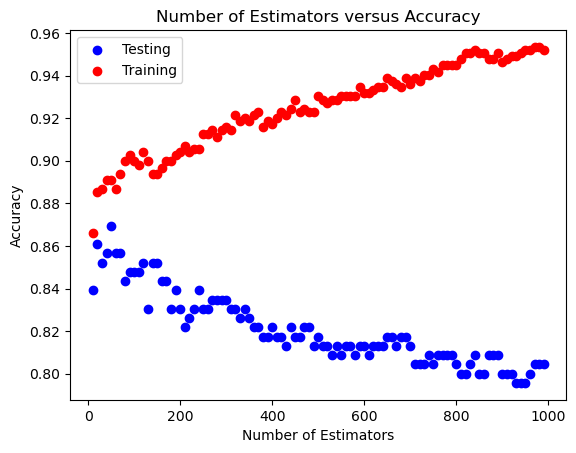

  0%|          | 0/9 [00:00<?, ?it/s]c:\Users\Eza\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Eza\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Eza\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
 33%|███▎      | 3/9 [00:00<00:00, 23.80it/s]c:\Users\Eza\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated

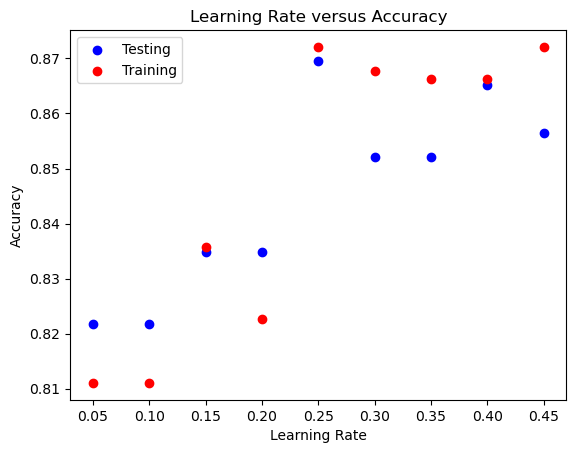

In [30]:


changed_parameter = []
training_scores = []
testing_scores = []



for n_est in tqdm(range(10, 1000, 10)):
        classy = AdaBoostClassifier(n_estimators=n_est)
        changed_parameter.append(int(n_est))
        classy.fit(x_train_scaled, y_train)
        testing_scores.append(classy.score(x_test_scaled, y_test))
        training_scores.append(classy.score(x_train_scaled, y_train))
        y_pred_train = classy.predict(x_train_scaled)
        y_pred_test = classy.predict(x_test_scaled)

        
fig, ax = plt.subplots()
ax.scatter(changed_parameter, testing_scores, c="blue", label="Testing")
ax.scatter(changed_parameter, training_scores, c="red", label="Training")
ax.legend()
X_text = "Number of Estimators"
plt.title(f"{X_text} versus Accuracy")
plt.xlabel(X_text)
plt.ylabel("Accuracy")
plt.show()



changed_parameter = []
training_scores = []
testing_scores = []



for lern in tqdm(np.arange(0.05, 0.5, 0.05)):
        classy = AdaBoostClassifier(n_estimators=10, learning_rate=lern)
        changed_parameter.append(lern)
        classy.fit(x_train_scaled, y_train)
        testing_scores.append(classy.score(x_test_scaled, y_test))
        training_scores.append(classy.score(x_train_scaled, y_train))
        y_pred_train = classy.predict(x_train_scaled)
        y_pred_test = classy.predict(x_test_scaled)

fig, ax = plt.subplots()
ax.scatter(changed_parameter, testing_scores, c="blue", label="Testing")
ax.scatter(changed_parameter, training_scores, c="red", label="Training")
ax.legend()
X_text = "Learning Rate"
plt.title(f"{X_text} versus Accuracy")
plt.xlabel(X_text)
plt.ylabel("Accuracy")
plt.show()





100%|██████████| 99/99 [01:39<00:00,  1.00s/it]


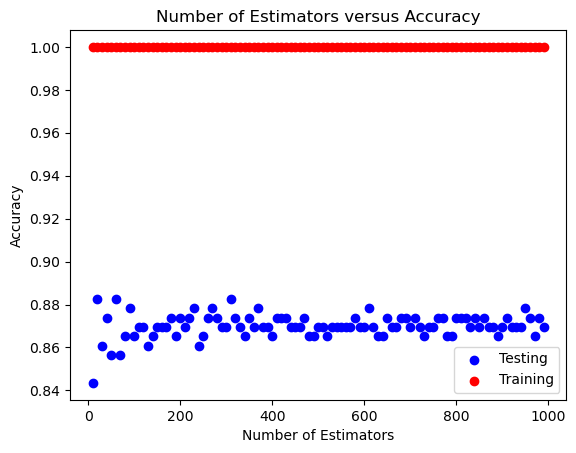

100%|██████████| 8/8 [00:00<00:00, 42.77it/s]


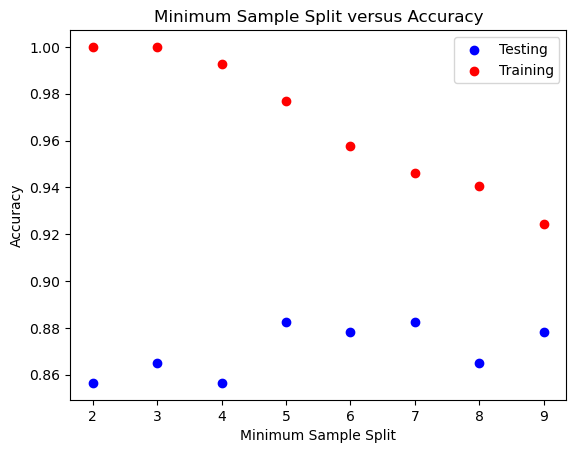

In [31]:


changed_parameter = []
training_scores = []
testing_scores = []



for n_est in tqdm(range(10, 1000, 10)):
        classy = ExtraTreesClassifier(n_estimators=n_est)
        changed_parameter.append(int(n_est))
        classy.fit(x_train_scaled, y_train)
        testing_scores.append(classy.score(x_test_scaled, y_test))
        training_scores.append(classy.score(x_train_scaled, y_train))
        y_pred_train = classy.predict(x_train_scaled)
        y_pred_test = classy.predict(x_test_scaled)

        
fig, ax = plt.subplots()
ax.scatter(changed_parameter, testing_scores, c="blue", label="Testing")
ax.scatter(changed_parameter, training_scores, c="red", label="Training")
ax.legend()
X_text = "Number of Estimators"
plt.title(f"{X_text} versus Accuracy")
plt.xlabel(X_text)
plt.ylabel("Accuracy")
plt.show()







changed_parameter = []
training_scores = []
testing_scores = []



for split in tqdm(range(2, 10)):
        classy = ExtraTreesClassifier(n_estimators=10, min_samples_split=split)
        changed_parameter.append(split)
        classy.fit(x_train_scaled, y_train)
        testing_scores.append(classy.score(x_test_scaled, y_test))
        training_scores.append(classy.score(x_train_scaled, y_train))
        y_pred_train = classy.predict(x_train_scaled)
        y_pred_test = classy.predict(x_test_scaled)

        
fig, ax = plt.subplots()
ax.scatter(changed_parameter, testing_scores, c="blue", label="Testing")
ax.scatter(changed_parameter, training_scores, c="red", label="Training")
ax.legend()
X_text = "Minimum Sample Split"
plt.title(f"{X_text} versus Accuracy")
plt.xlabel(X_text)
plt.ylabel("Accuracy")
plt.show()



  3%|▎         | 3/99 [00:00<00:04, 22.19it/s]

Score differences: 0.13039686552072793 at 10, training acc: 0.9869186046511628 and testing acc: 0.8565217391304348
Score differences: 0.10288169868554098 at 20, training acc: 0.9941860465116279 and testing acc: 0.8913043478260869
Score differences: 0.1217264914054601 at 30, training acc: 0.9956395348837209 and testing acc: 0.8739130434782608
Score differences: 0.10724216380182006 at 40, training acc: 0.998546511627907 and testing acc: 0.8913043478260869
Score differences: 0.10289433771486345 at 50, training acc: 0.998546511627907 and testing acc: 0.8956521739130435


  6%|▌         | 6/99 [00:00<00:07, 12.30it/s]

Score differences: 0.12173913043478257 at 60, training acc: 1.0 and testing acc: 0.8782608695652174
Score differences: 0.13767694641051564 at 70, training acc: 0.998546511627907 and testing acc: 0.8608695652173913


  8%|▊         | 8/99 [00:00<00:10,  8.96it/s]

Score differences: 0.11739130434782608 at 80, training acc: 1.0 and testing acc: 0.8826086956521739
Score differences: 0.10869565217391308 at 90, training acc: 1.0 and testing acc: 0.8913043478260869


 10%|█         | 10/99 [00:01<00:12,  7.11it/s]

Score differences: 0.11304347826086958 at 100, training acc: 1.0 and testing acc: 0.8869565217391304


 11%|█         | 11/99 [00:01<00:13,  6.35it/s]

Score differences: 0.12173913043478257 at 110, training acc: 1.0 and testing acc: 0.8782608695652174


 12%|█▏        | 12/99 [00:01<00:15,  5.53it/s]

Score differences: 0.10869565217391308 at 120, training acc: 1.0 and testing acc: 0.8913043478260869


 13%|█▎        | 13/99 [00:01<00:17,  4.80it/s]

Score differences: 0.13478260869565217 at 130, training acc: 1.0 and testing acc: 0.8652173913043478


 14%|█▍        | 14/99 [00:02<00:19,  4.32it/s]

Score differences: 0.12173913043478257 at 140, training acc: 1.0 and testing acc: 0.8782608695652174


 15%|█▌        | 15/99 [00:02<00:21,  3.90it/s]

Score differences: 0.12608695652173918 at 150, training acc: 1.0 and testing acc: 0.8739130434782608


 16%|█▌        | 16/99 [00:02<00:22,  3.61it/s]

Score differences: 0.11739130434782608 at 160, training acc: 1.0 and testing acc: 0.8826086956521739


 17%|█▋        | 17/99 [00:03<00:24,  3.36it/s]

Score differences: 0.12608695652173918 at 170, training acc: 1.0 and testing acc: 0.8739130434782608


 18%|█▊        | 18/99 [00:03<00:26,  3.09it/s]

Score differences: 0.11304347826086958 at 180, training acc: 1.0 and testing acc: 0.8869565217391304


 19%|█▉        | 19/99 [00:04<00:27,  2.92it/s]

Score differences: 0.11304347826086958 at 190, training acc: 1.0 and testing acc: 0.8869565217391304


 20%|██        | 20/99 [00:04<00:28,  2.76it/s]

Score differences: 0.11739130434782608 at 200, training acc: 1.0 and testing acc: 0.8826086956521739


 21%|██        | 21/99 [00:04<00:29,  2.61it/s]

Score differences: 0.09999999999999998 at 210, training acc: 1.0 and testing acc: 0.9


 22%|██▏       | 22/99 [00:05<00:31,  2.47it/s]

Score differences: 0.09565217391304348 at 220, training acc: 1.0 and testing acc: 0.9043478260869565


 23%|██▎       | 23/99 [00:05<00:32,  2.33it/s]

Score differences: 0.12173913043478257 at 230, training acc: 1.0 and testing acc: 0.8782608695652174


 24%|██▍       | 24/99 [00:06<00:33,  2.21it/s]

Score differences: 0.10869565217391308 at 240, training acc: 1.0 and testing acc: 0.8913043478260869


 25%|██▌       | 25/99 [00:06<00:34,  2.12it/s]

Score differences: 0.11304347826086958 at 250, training acc: 1.0 and testing acc: 0.8869565217391304


 26%|██▋       | 26/99 [00:07<00:35,  2.04it/s]

Score differences: 0.11304347826086958 at 260, training acc: 1.0 and testing acc: 0.8869565217391304


 27%|██▋       | 27/99 [00:07<00:36,  1.95it/s]

Score differences: 0.11739130434782608 at 270, training acc: 1.0 and testing acc: 0.8826086956521739


 28%|██▊       | 28/99 [00:08<00:37,  1.89it/s]

Score differences: 0.10869565217391308 at 280, training acc: 1.0 and testing acc: 0.8913043478260869


 29%|██▉       | 29/99 [00:09<00:38,  1.81it/s]

Score differences: 0.12608695652173918 at 290, training acc: 1.0 and testing acc: 0.8739130434782608


 30%|███       | 30/99 [00:09<00:39,  1.74it/s]

Score differences: 0.10869565217391308 at 300, training acc: 1.0 and testing acc: 0.8913043478260869


 31%|███▏      | 31/99 [00:10<00:40,  1.69it/s]

Score differences: 0.12608695652173918 at 310, training acc: 1.0 and testing acc: 0.8739130434782608


 32%|███▏      | 32/99 [00:11<00:40,  1.63it/s]

Score differences: 0.11304347826086958 at 320, training acc: 1.0 and testing acc: 0.8869565217391304


 33%|███▎      | 33/99 [00:11<00:41,  1.59it/s]

Score differences: 0.11739130434782608 at 330, training acc: 1.0 and testing acc: 0.8826086956521739


 34%|███▍      | 34/99 [00:12<00:42,  1.52it/s]

Score differences: 0.10869565217391308 at 340, training acc: 1.0 and testing acc: 0.8913043478260869


 35%|███▌      | 35/99 [00:13<00:43,  1.48it/s]

Score differences: 0.10869565217391308 at 350, training acc: 1.0 and testing acc: 0.8913043478260869


 36%|███▋      | 36/99 [00:13<00:43,  1.45it/s]

Score differences: 0.10869565217391308 at 360, training acc: 1.0 and testing acc: 0.8913043478260869


 37%|███▋      | 37/99 [00:14<00:44,  1.41it/s]

Score differences: 0.11304347826086958 at 370, training acc: 1.0 and testing acc: 0.8869565217391304


 38%|███▊      | 38/99 [00:15<00:44,  1.37it/s]

Score differences: 0.10869565217391308 at 380, training acc: 1.0 and testing acc: 0.8913043478260869


 39%|███▉      | 39/99 [00:16<00:45,  1.33it/s]

Score differences: 0.10869565217391308 at 390, training acc: 1.0 and testing acc: 0.8913043478260869


 40%|████      | 40/99 [00:17<00:45,  1.29it/s]

Score differences: 0.12173913043478257 at 400, training acc: 1.0 and testing acc: 0.8782608695652174


 41%|████▏     | 41/99 [00:17<00:46,  1.26it/s]

Score differences: 0.11304347826086958 at 410, training acc: 1.0 and testing acc: 0.8869565217391304


 42%|████▏     | 42/99 [00:18<00:46,  1.23it/s]

Score differences: 0.11304347826086958 at 420, training acc: 1.0 and testing acc: 0.8869565217391304


 43%|████▎     | 43/99 [00:19<00:46,  1.20it/s]

Score differences: 0.11739130434782608 at 430, training acc: 1.0 and testing acc: 0.8826086956521739


 44%|████▍     | 44/99 [00:20<00:46,  1.18it/s]

Score differences: 0.10434782608695647 at 440, training acc: 1.0 and testing acc: 0.8956521739130435


 45%|████▌     | 45/99 [00:21<00:47,  1.15it/s]

Score differences: 0.12173913043478257 at 450, training acc: 1.0 and testing acc: 0.8782608695652174


 46%|████▋     | 46/99 [00:22<00:47,  1.12it/s]

Score differences: 0.10869565217391308 at 460, training acc: 1.0 and testing acc: 0.8913043478260869


 47%|████▋     | 47/99 [00:23<00:47,  1.10it/s]

Score differences: 0.10434782608695647 at 470, training acc: 1.0 and testing acc: 0.8956521739130435


 48%|████▊     | 48/99 [00:24<00:47,  1.07it/s]

Score differences: 0.10869565217391308 at 480, training acc: 1.0 and testing acc: 0.8913043478260869


 49%|████▉     | 49/99 [00:25<00:47,  1.05it/s]

Score differences: 0.12173913043478257 at 490, training acc: 1.0 and testing acc: 0.8782608695652174


 51%|█████     | 50/99 [00:26<00:47,  1.03it/s]

Score differences: 0.10434782608695647 at 500, training acc: 1.0 and testing acc: 0.8956521739130435


 52%|█████▏    | 51/99 [00:27<00:48,  1.00s/it]

Score differences: 0.12173913043478257 at 510, training acc: 1.0 and testing acc: 0.8782608695652174


 53%|█████▎    | 52/99 [00:28<00:48,  1.02s/it]

Score differences: 0.12608695652173918 at 520, training acc: 1.0 and testing acc: 0.8739130434782608


 54%|█████▎    | 53/99 [00:29<00:48,  1.05s/it]

Score differences: 0.11304347826086958 at 530, training acc: 1.0 and testing acc: 0.8869565217391304


 55%|█████▍    | 54/99 [00:30<00:47,  1.06s/it]

Score differences: 0.10869565217391308 at 540, training acc: 1.0 and testing acc: 0.8913043478260869


 56%|█████▌    | 55/99 [00:31<00:47,  1.08s/it]

Score differences: 0.10869565217391308 at 550, training acc: 1.0 and testing acc: 0.8913043478260869


 57%|█████▋    | 56/99 [00:32<00:47,  1.10s/it]

Score differences: 0.11739130434782608 at 560, training acc: 1.0 and testing acc: 0.8826086956521739


 58%|█████▊    | 57/99 [00:34<00:46,  1.12s/it]

Score differences: 0.10869565217391308 at 570, training acc: 1.0 and testing acc: 0.8913043478260869


 59%|█████▊    | 58/99 [00:35<00:46,  1.14s/it]

Score differences: 0.11304347826086958 at 580, training acc: 1.0 and testing acc: 0.8869565217391304


 60%|█████▉    | 59/99 [00:36<00:46,  1.17s/it]

Score differences: 0.11304347826086958 at 590, training acc: 1.0 and testing acc: 0.8869565217391304


 61%|██████    | 60/99 [00:37<00:46,  1.19s/it]

Score differences: 0.11739130434782608 at 600, training acc: 1.0 and testing acc: 0.8826086956521739


 62%|██████▏   | 61/99 [00:39<00:45,  1.20s/it]

Score differences: 0.10869565217391308 at 610, training acc: 1.0 and testing acc: 0.8913043478260869


 63%|██████▎   | 62/99 [00:40<00:45,  1.22s/it]

Score differences: 0.11739130434782608 at 620, training acc: 1.0 and testing acc: 0.8826086956521739


 64%|██████▎   | 63/99 [00:41<00:44,  1.24s/it]

Score differences: 0.11304347826086958 at 630, training acc: 1.0 and testing acc: 0.8869565217391304


 65%|██████▍   | 64/99 [00:42<00:44,  1.26s/it]

Score differences: 0.11304347826086958 at 640, training acc: 1.0 and testing acc: 0.8869565217391304


 66%|██████▌   | 65/99 [00:44<00:43,  1.28s/it]

Score differences: 0.12173913043478257 at 650, training acc: 1.0 and testing acc: 0.8782608695652174


 67%|██████▋   | 66/99 [00:45<00:42,  1.30s/it]

Score differences: 0.10869565217391308 at 660, training acc: 1.0 and testing acc: 0.8913043478260869


 68%|██████▊   | 67/99 [00:46<00:42,  1.32s/it]

Score differences: 0.10869565217391308 at 670, training acc: 1.0 and testing acc: 0.8913043478260869


 69%|██████▊   | 68/99 [00:48<00:41,  1.35s/it]

Score differences: 0.10869565217391308 at 680, training acc: 1.0 and testing acc: 0.8913043478260869


 70%|██████▉   | 69/99 [00:49<00:41,  1.38s/it]

Score differences: 0.11304347826086958 at 690, training acc: 1.0 and testing acc: 0.8869565217391304


 71%|███████   | 70/99 [00:51<00:40,  1.40s/it]

Score differences: 0.11304347826086958 at 700, training acc: 1.0 and testing acc: 0.8869565217391304


 72%|███████▏  | 71/99 [00:52<00:39,  1.41s/it]

Score differences: 0.11304347826086958 at 710, training acc: 1.0 and testing acc: 0.8869565217391304


 73%|███████▎  | 72/99 [00:54<00:38,  1.43s/it]

Score differences: 0.12173913043478257 at 720, training acc: 1.0 and testing acc: 0.8782608695652174


 74%|███████▎  | 73/99 [00:55<00:37,  1.45s/it]

Score differences: 0.11304347826086958 at 730, training acc: 1.0 and testing acc: 0.8869565217391304


 75%|███████▍  | 74/99 [00:57<00:36,  1.47s/it]

Score differences: 0.12173913043478257 at 740, training acc: 1.0 and testing acc: 0.8782608695652174


 76%|███████▌  | 75/99 [00:58<00:35,  1.49s/it]

Score differences: 0.10869565217391308 at 750, training acc: 1.0 and testing acc: 0.8913043478260869


 77%|███████▋  | 76/99 [01:00<00:34,  1.51s/it]

Score differences: 0.10434782608695647 at 760, training acc: 1.0 and testing acc: 0.8956521739130435


 78%|███████▊  | 77/99 [01:01<00:33,  1.53s/it]

Score differences: 0.11304347826086958 at 770, training acc: 1.0 and testing acc: 0.8869565217391304


 79%|███████▉  | 78/99 [01:03<00:32,  1.55s/it]

Score differences: 0.11304347826086958 at 780, training acc: 1.0 and testing acc: 0.8869565217391304


 80%|███████▉  | 79/99 [01:05<00:31,  1.57s/it]

Score differences: 0.10869565217391308 at 790, training acc: 1.0 and testing acc: 0.8913043478260869


 81%|████████  | 80/99 [01:06<00:30,  1.59s/it]

Score differences: 0.11304347826086958 at 800, training acc: 1.0 and testing acc: 0.8869565217391304


 82%|████████▏ | 81/99 [01:08<00:29,  1.61s/it]

Score differences: 0.11739130434782608 at 810, training acc: 1.0 and testing acc: 0.8826086956521739


 83%|████████▎ | 82/99 [01:10<00:27,  1.63s/it]

Score differences: 0.11304347826086958 at 820, training acc: 1.0 and testing acc: 0.8869565217391304


 84%|████████▍ | 83/99 [01:11<00:26,  1.65s/it]

Score differences: 0.10869565217391308 at 830, training acc: 1.0 and testing acc: 0.8913043478260869


 85%|████████▍ | 84/99 [01:13<00:25,  1.67s/it]

Score differences: 0.10869565217391308 at 840, training acc: 1.0 and testing acc: 0.8913043478260869


 86%|████████▌ | 85/99 [01:15<00:23,  1.69s/it]

Score differences: 0.12173913043478257 at 850, training acc: 1.0 and testing acc: 0.8782608695652174


 87%|████████▋ | 86/99 [01:16<00:22,  1.71s/it]

Score differences: 0.10869565217391308 at 860, training acc: 1.0 and testing acc: 0.8913043478260869


 88%|████████▊ | 87/99 [01:18<00:20,  1.74s/it]

Score differences: 0.11739130434782608 at 870, training acc: 1.0 and testing acc: 0.8826086956521739


 89%|████████▉ | 88/99 [01:20<00:19,  1.75s/it]

Score differences: 0.11304347826086958 at 880, training acc: 1.0 and testing acc: 0.8869565217391304


 90%|████████▉ | 89/99 [01:22<00:17,  1.77s/it]

Score differences: 0.11304347826086958 at 890, training acc: 1.0 and testing acc: 0.8869565217391304


 91%|█████████ | 90/99 [01:24<00:16,  1.80s/it]

Score differences: 0.11304347826086958 at 900, training acc: 1.0 and testing acc: 0.8869565217391304


 92%|█████████▏| 91/99 [01:26<00:14,  1.82s/it]

Score differences: 0.10869565217391308 at 910, training acc: 1.0 and testing acc: 0.8913043478260869


 93%|█████████▎| 92/99 [01:28<00:13,  1.86s/it]

Score differences: 0.09565217391304348 at 920, training acc: 1.0 and testing acc: 0.9043478260869565


 94%|█████████▍| 93/99 [01:30<00:11,  1.96s/it]

Score differences: 0.10869565217391308 at 930, training acc: 1.0 and testing acc: 0.8913043478260869


 95%|█████████▍| 94/99 [01:32<00:09,  2.00s/it]

Score differences: 0.10434782608695647 at 940, training acc: 1.0 and testing acc: 0.8956521739130435


 96%|█████████▌| 95/99 [01:34<00:08,  2.02s/it]

Score differences: 0.10434782608695647 at 950, training acc: 1.0 and testing acc: 0.8956521739130435


 97%|█████████▋| 96/99 [01:36<00:06,  2.05s/it]

Score differences: 0.10434782608695647 at 960, training acc: 1.0 and testing acc: 0.8956521739130435


 98%|█████████▊| 97/99 [01:38<00:04,  2.07s/it]

Score differences: 0.10434782608695647 at 970, training acc: 1.0 and testing acc: 0.8956521739130435


 99%|█████████▉| 98/99 [01:40<00:02,  2.07s/it]

Score differences: 0.11304347826086958 at 980, training acc: 1.0 and testing acc: 0.8869565217391304


100%|██████████| 99/99 [01:42<00:00,  1.04s/it]

Score differences: 0.11739130434782608 at 990, training acc: 1.0 and testing acc: 0.8826086956521739


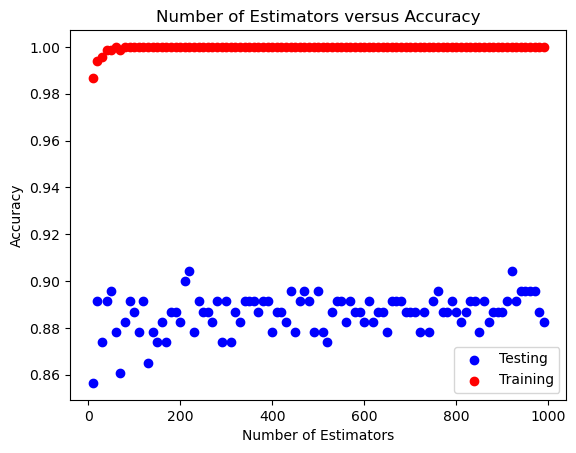

 25%|██▌       | 2/8 [00:00<00:00, 10.75it/s]

Score differences: 0.13043478260869568 at 2, training acc: 1.0 and testing acc: 0.8695652173913043
Score differences: 0.1072168857431749 at 3, training acc: 0.9898255813953488 and testing acc: 0.8826086956521739
Score differences: 0.08834681496461072 at 4, training acc: 0.9796511627906976 and testing acc: 0.8913043478260869


 75%|███████▌  | 6/8 [00:00<00:00, 11.40it/s]

Score differences: 0.09556370070778564 at 5, training acc: 0.9694767441860465 and testing acc: 0.8739130434782608
Score differences: 0.08104145601617796 at 6, training acc: 0.9593023255813954 and testing acc: 0.8782608695652174
Score differences: 0.0723205257836198 at 7, training acc: 0.9505813953488372 and testing acc: 0.8782608695652174


100%|██████████| 8/8 [00:00<00:00, 11.27it/s]


Score differences: 0.07376137512639036 at 8, training acc: 0.9476744186046512 and testing acc: 0.8739130434782608
Score differences: 0.03605915065722953 at 9, training acc: 0.940406976744186 and testing acc: 0.9043478260869565


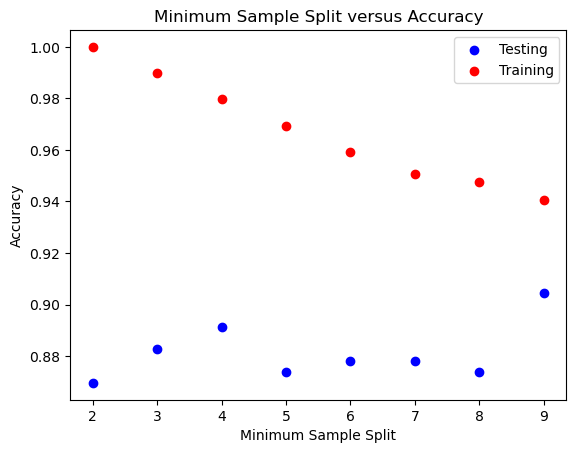

In [40]:


changed_parameter = []
training_scores = []
testing_scores = []



for n_est in tqdm(range(10, 1000, 10)):
        classy = RandomForestClassifier(n_estimators=n_est)
        changed_parameter.append(int(n_est))
        classy.fit(x_train_scaled, y_train)
        testing_scores.append(classy.score(x_test_scaled, y_test))
        training_scores.append(classy.score(x_train_scaled, y_train))
        print(f"Score differences: {training_scores[-1] - testing_scores[-1]} at {int(n_est)}, training acc: {training_scores[-1]} and testing acc: {testing_scores[-1]}")

        
fig, ax = plt.subplots()
ax.scatter(changed_parameter, testing_scores, c="blue", label="Testing")
ax.scatter(changed_parameter, training_scores, c="red", label="Training")
ax.legend()
X_text = "Number of Estimators"
plt.title(f"{X_text} versus Accuracy")
plt.xlabel(X_text)
plt.ylabel("Accuracy")
plt.show()



changed_parameter = []
training_scores = []
testing_scores = []


for split in tqdm(range(2, 10)):
        classy = RandomForestClassifier(n_estimators=40, min_samples_split=split)
        changed_parameter.append(split)
        classy.fit(x_train_scaled, y_train)
        testing_scores.append(classy.score(x_test_scaled, y_test))
        training_scores.append(classy.score(x_train_scaled, y_train))
        print(f"Score differences: {training_scores[-1] - testing_scores[-1]} at {split}, training acc: {training_scores[-1]} and testing acc: {testing_scores[-1]}")


        
fig, ax = plt.subplots()
ax.scatter(changed_parameter, testing_scores, c="blue", label="Testing")
ax.scatter(changed_parameter, training_scores, c="red", label="Training")
ax.legend()
X_text = "Minimum Sample Split"
plt.title(f"{X_text} versus Accuracy")
plt.xlabel(X_text)
plt.ylabel("Accuracy")
plt.show()



  1%|          | 1/99 [00:00<00:16,  5.79it/s]

Score differences: 0.1129676440849342 at 10, training acc: 0.9738372093023255 and testing acc: 0.8608695652173913


  2%|▏         | 2/99 [00:00<00:22,  4.33it/s]

Score differences: 0.14347826086956517 at 20, training acc: 1.0 and testing acc: 0.8565217391304348


  3%|▎         | 3/99 [00:00<00:26,  3.67it/s]

Score differences: 0.14347826086956517 at 30, training acc: 1.0 and testing acc: 0.8565217391304348


  4%|▍         | 4/99 [00:01<00:30,  3.09it/s]

Score differences: 0.14347826086956517 at 40, training acc: 1.0 and testing acc: 0.8565217391304348


  5%|▌         | 5/99 [00:01<00:31,  3.03it/s]

Score differences: 0.14347826086956517 at 50, training acc: 1.0 and testing acc: 0.8565217391304348


  6%|▌         | 6/99 [00:01<00:31,  2.98it/s]

Score differences: 0.14347826086956517 at 60, training acc: 1.0 and testing acc: 0.8565217391304348


  7%|▋         | 7/99 [00:02<00:31,  2.95it/s]

Score differences: 0.14347826086956517 at 70, training acc: 1.0 and testing acc: 0.8565217391304348


  8%|▊         | 8/99 [00:02<00:30,  3.01it/s]

Score differences: 0.14347826086956517 at 80, training acc: 1.0 and testing acc: 0.8565217391304348


  9%|▉         | 9/99 [00:02<00:30,  2.97it/s]

Score differences: 0.14347826086956517 at 90, training acc: 1.0 and testing acc: 0.8565217391304348


 10%|█         | 10/99 [00:03<00:31,  2.84it/s]

Score differences: 0.14347826086956517 at 100, training acc: 1.0 and testing acc: 0.8565217391304348


 11%|█         | 11/99 [00:03<00:30,  2.88it/s]

Score differences: 0.14347826086956517 at 110, training acc: 1.0 and testing acc: 0.8565217391304348


 12%|█▏        | 12/99 [00:03<00:30,  2.88it/s]

Score differences: 0.14347826086956517 at 120, training acc: 1.0 and testing acc: 0.8565217391304348


 13%|█▎        | 13/99 [00:04<00:29,  2.94it/s]

Score differences: 0.14347826086956517 at 130, training acc: 1.0 and testing acc: 0.8565217391304348


 14%|█▍        | 14/99 [00:04<00:28,  2.94it/s]

Score differences: 0.14347826086956517 at 140, training acc: 1.0 and testing acc: 0.8565217391304348


 15%|█▌        | 15/99 [00:04<00:30,  2.80it/s]

Score differences: 0.14347826086956517 at 150, training acc: 1.0 and testing acc: 0.8565217391304348


 16%|█▌        | 16/99 [00:05<00:29,  2.84it/s]

Score differences: 0.14347826086956517 at 160, training acc: 1.0 and testing acc: 0.8565217391304348


 17%|█▋        | 17/99 [00:05<00:27,  2.93it/s]

Score differences: 0.14347826086956517 at 170, training acc: 1.0 and testing acc: 0.8565217391304348


 18%|█▊        | 18/99 [00:05<00:27,  2.98it/s]

Score differences: 0.14347826086956517 at 180, training acc: 1.0 and testing acc: 0.8565217391304348


 19%|█▉        | 19/99 [00:06<00:26,  3.02it/s]

Score differences: 0.14347826086956517 at 190, training acc: 1.0 and testing acc: 0.8565217391304348


 20%|██        | 20/99 [00:06<00:25,  3.05it/s]

Score differences: 0.14347826086956517 at 200, training acc: 1.0 and testing acc: 0.8565217391304348


 21%|██        | 21/99 [00:06<00:26,  3.00it/s]

Score differences: 0.14347826086956517 at 210, training acc: 1.0 and testing acc: 0.8565217391304348


 22%|██▏       | 22/99 [00:07<00:25,  3.04it/s]

Score differences: 0.14347826086956517 at 220, training acc: 1.0 and testing acc: 0.8565217391304348


 23%|██▎       | 23/99 [00:07<00:24,  3.06it/s]

Score differences: 0.14347826086956517 at 230, training acc: 1.0 and testing acc: 0.8565217391304348


 24%|██▍       | 24/99 [00:07<00:25,  3.00it/s]

Score differences: 0.14347826086956517 at 240, training acc: 1.0 and testing acc: 0.8565217391304348


 25%|██▌       | 25/99 [00:08<00:24,  3.03it/s]

Score differences: 0.14347826086956517 at 250, training acc: 1.0 and testing acc: 0.8565217391304348


 26%|██▋       | 26/99 [00:08<00:24,  2.96it/s]

Score differences: 0.14347826086956517 at 260, training acc: 1.0 and testing acc: 0.8565217391304348


 27%|██▋       | 27/99 [00:09<00:25,  2.81it/s]

Score differences: 0.14347826086956517 at 270, training acc: 1.0 and testing acc: 0.8565217391304348


 28%|██▊       | 28/99 [00:09<00:25,  2.84it/s]

Score differences: 0.14347826086956517 at 280, training acc: 1.0 and testing acc: 0.8565217391304348


 29%|██▉       | 29/99 [00:09<00:24,  2.89it/s]

Score differences: 0.14347826086956517 at 290, training acc: 1.0 and testing acc: 0.8565217391304348


 30%|███       | 30/99 [00:10<00:23,  2.95it/s]

Score differences: 0.14347826086956517 at 300, training acc: 1.0 and testing acc: 0.8565217391304348


 31%|███▏      | 31/99 [00:10<00:22,  3.01it/s]

Score differences: 0.14347826086956517 at 310, training acc: 1.0 and testing acc: 0.8565217391304348


 32%|███▏      | 32/99 [00:10<00:22,  2.93it/s]

Score differences: 0.14347826086956517 at 320, training acc: 1.0 and testing acc: 0.8565217391304348


 33%|███▎      | 33/99 [00:11<00:22,  3.00it/s]

Score differences: 0.14347826086956517 at 330, training acc: 1.0 and testing acc: 0.8565217391304348


 34%|███▍      | 34/99 [00:11<00:21,  3.06it/s]

Score differences: 0.14347826086956517 at 340, training acc: 1.0 and testing acc: 0.8565217391304348


 35%|███▌      | 35/99 [00:11<00:20,  3.11it/s]

Score differences: 0.14347826086956517 at 350, training acc: 1.0 and testing acc: 0.8565217391304348


 36%|███▋      | 36/99 [00:11<00:20,  3.12it/s]

Score differences: 0.14347826086956517 at 360, training acc: 1.0 and testing acc: 0.8565217391304348


 37%|███▋      | 37/99 [00:12<00:21,  2.89it/s]

Score differences: 0.14347826086956517 at 370, training acc: 1.0 and testing acc: 0.8565217391304348


 38%|███▊      | 38/99 [00:12<00:20,  2.97it/s]

Score differences: 0.14347826086956517 at 380, training acc: 1.0 and testing acc: 0.8565217391304348


 39%|███▉      | 39/99 [00:13<00:20,  2.94it/s]

Score differences: 0.14347826086956517 at 390, training acc: 1.0 and testing acc: 0.8565217391304348


 40%|████      | 40/99 [00:13<00:19,  2.97it/s]

Score differences: 0.14347826086956517 at 400, training acc: 1.0 and testing acc: 0.8565217391304348


 41%|████▏     | 41/99 [00:13<00:19,  2.98it/s]

Score differences: 0.14347826086956517 at 410, training acc: 1.0 and testing acc: 0.8565217391304348


 42%|████▏     | 42/99 [00:14<00:19,  2.99it/s]

Score differences: 0.14347826086956517 at 420, training acc: 1.0 and testing acc: 0.8565217391304348


 43%|████▎     | 43/99 [00:14<00:19,  2.91it/s]

Score differences: 0.14347826086956517 at 430, training acc: 1.0 and testing acc: 0.8565217391304348


 44%|████▍     | 44/99 [00:14<00:18,  2.96it/s]

Score differences: 0.14347826086956517 at 440, training acc: 1.0 and testing acc: 0.8565217391304348


 45%|████▌     | 45/99 [00:15<00:17,  3.03it/s]

Score differences: 0.14347826086956517 at 450, training acc: 1.0 and testing acc: 0.8565217391304348


 46%|████▋     | 46/99 [00:15<00:17,  3.08it/s]

Score differences: 0.14347826086956517 at 460, training acc: 1.0 and testing acc: 0.8565217391304348


 47%|████▋     | 47/99 [00:15<00:16,  3.10it/s]

Score differences: 0.14347826086956517 at 470, training acc: 1.0 and testing acc: 0.8565217391304348


 48%|████▊     | 48/99 [00:16<00:17,  2.98it/s]

Score differences: 0.14347826086956517 at 480, training acc: 1.0 and testing acc: 0.8565217391304348


 49%|████▉     | 49/99 [00:16<00:16,  3.01it/s]

Score differences: 0.14347826086956517 at 490, training acc: 1.0 and testing acc: 0.8565217391304348


 51%|█████     | 50/99 [00:16<00:16,  3.05it/s]

Score differences: 0.14347826086956517 at 500, training acc: 1.0 and testing acc: 0.8565217391304348


 52%|█████▏    | 51/99 [00:16<00:15,  3.07it/s]

Score differences: 0.14347826086956517 at 510, training acc: 1.0 and testing acc: 0.8565217391304348


 53%|█████▎    | 52/99 [00:17<00:15,  3.09it/s]

Score differences: 0.14347826086956517 at 520, training acc: 1.0 and testing acc: 0.8565217391304348


 54%|█████▎    | 53/99 [00:17<00:14,  3.12it/s]

Score differences: 0.14347826086956517 at 530, training acc: 1.0 and testing acc: 0.8565217391304348


 55%|█████▍    | 54/99 [00:17<00:15,  3.00it/s]

Score differences: 0.14347826086956517 at 540, training acc: 1.0 and testing acc: 0.8565217391304348


 56%|█████▌    | 55/99 [00:18<00:14,  2.98it/s]

Score differences: 0.14347826086956517 at 550, training acc: 1.0 and testing acc: 0.8565217391304348


 57%|█████▋    | 56/99 [00:18<00:14,  3.04it/s]

Score differences: 0.14347826086956517 at 560, training acc: 1.0 and testing acc: 0.8565217391304348


 58%|█████▊    | 57/99 [00:18<00:13,  3.06it/s]

Score differences: 0.14347826086956517 at 570, training acc: 1.0 and testing acc: 0.8565217391304348


 59%|█████▊    | 58/99 [00:19<00:13,  3.11it/s]

Score differences: 0.14347826086956517 at 580, training acc: 1.0 and testing acc: 0.8565217391304348


 60%|█████▉    | 59/99 [00:19<00:12,  3.14it/s]

Score differences: 0.14347826086956517 at 590, training acc: 1.0 and testing acc: 0.8565217391304348


 61%|██████    | 60/99 [00:19<00:12,  3.07it/s]

Score differences: 0.14347826086956517 at 600, training acc: 1.0 and testing acc: 0.8565217391304348


 62%|██████▏   | 61/99 [00:20<00:12,  3.09it/s]

Score differences: 0.14347826086956517 at 610, training acc: 1.0 and testing acc: 0.8565217391304348


 63%|██████▎   | 62/99 [00:20<00:11,  3.12it/s]

Score differences: 0.14347826086956517 at 620, training acc: 1.0 and testing acc: 0.8565217391304348


 64%|██████▎   | 63/99 [00:20<00:11,  3.14it/s]

Score differences: 0.14347826086956517 at 630, training acc: 1.0 and testing acc: 0.8565217391304348


 65%|██████▍   | 64/99 [00:21<00:11,  3.15it/s]

Score differences: 0.14347826086956517 at 640, training acc: 1.0 and testing acc: 0.8565217391304348


 66%|██████▌   | 65/99 [00:21<00:10,  3.16it/s]

Score differences: 0.14347826086956517 at 650, training acc: 1.0 and testing acc: 0.8565217391304348


 67%|██████▋   | 66/99 [00:21<00:11,  2.91it/s]

Score differences: 0.14347826086956517 at 660, training acc: 1.0 and testing acc: 0.8565217391304348


 68%|██████▊   | 67/99 [00:22<00:10,  2.97it/s]

Score differences: 0.14347826086956517 at 670, training acc: 1.0 and testing acc: 0.8565217391304348


 69%|██████▊   | 68/99 [00:22<00:10,  2.99it/s]

Score differences: 0.14347826086956517 at 680, training acc: 1.0 and testing acc: 0.8565217391304348


 70%|██████▉   | 69/99 [00:22<00:09,  3.03it/s]

Score differences: 0.14347826086956517 at 690, training acc: 1.0 and testing acc: 0.8565217391304348


 71%|███████   | 70/99 [00:23<00:09,  3.06it/s]

Score differences: 0.14347826086956517 at 700, training acc: 1.0 and testing acc: 0.8565217391304348


 72%|███████▏  | 71/99 [00:23<00:09,  3.08it/s]

Score differences: 0.14347826086956517 at 710, training acc: 1.0 and testing acc: 0.8565217391304348


 73%|███████▎  | 72/99 [00:23<00:09,  2.96it/s]

Score differences: 0.14347826086956517 at 720, training acc: 1.0 and testing acc: 0.8565217391304348


 74%|███████▎  | 73/99 [00:24<00:08,  3.03it/s]

Score differences: 0.14347826086956517 at 730, training acc: 1.0 and testing acc: 0.8565217391304348


 75%|███████▍  | 74/99 [00:24<00:08,  3.06it/s]

Score differences: 0.14347826086956517 at 740, training acc: 1.0 and testing acc: 0.8565217391304348


 76%|███████▌  | 75/99 [00:24<00:07,  3.10it/s]

Score differences: 0.14347826086956517 at 750, training acc: 1.0 and testing acc: 0.8565217391304348


 77%|███████▋  | 76/99 [00:25<00:07,  3.12it/s]

Score differences: 0.14347826086956517 at 760, training acc: 1.0 and testing acc: 0.8565217391304348


 78%|███████▊  | 77/99 [00:25<00:07,  3.01it/s]

Score differences: 0.14347826086956517 at 770, training acc: 1.0 and testing acc: 0.8565217391304348


 79%|███████▉  | 78/99 [00:25<00:06,  3.06it/s]

Score differences: 0.14347826086956517 at 780, training acc: 1.0 and testing acc: 0.8565217391304348


 80%|███████▉  | 79/99 [00:26<00:06,  3.09it/s]

Score differences: 0.14347826086956517 at 790, training acc: 1.0 and testing acc: 0.8565217391304348


 81%|████████  | 80/99 [00:26<00:06,  3.07it/s]

Score differences: 0.14347826086956517 at 800, training acc: 1.0 and testing acc: 0.8565217391304348


 82%|████████▏ | 81/99 [00:26<00:05,  3.11it/s]

Score differences: 0.14347826086956517 at 810, training acc: 1.0 and testing acc: 0.8565217391304348


 83%|████████▎ | 82/99 [00:27<00:05,  3.12it/s]

Score differences: 0.14347826086956517 at 820, training acc: 1.0 and testing acc: 0.8565217391304348


 84%|████████▍ | 83/99 [00:27<00:05,  3.00it/s]

Score differences: 0.14347826086956517 at 830, training acc: 1.0 and testing acc: 0.8565217391304348


 85%|████████▍ | 84/99 [00:27<00:04,  3.05it/s]

Score differences: 0.14347826086956517 at 840, training acc: 1.0 and testing acc: 0.8565217391304348


 86%|████████▌ | 85/99 [00:28<00:04,  3.08it/s]

Score differences: 0.14347826086956517 at 850, training acc: 1.0 and testing acc: 0.8565217391304348


 87%|████████▋ | 86/99 [00:28<00:04,  3.09it/s]

Score differences: 0.14347826086956517 at 860, training acc: 1.0 and testing acc: 0.8565217391304348


 88%|████████▊ | 87/99 [00:28<00:03,  3.12it/s]

Score differences: 0.14347826086956517 at 870, training acc: 1.0 and testing acc: 0.8565217391304348


 89%|████████▉ | 88/99 [00:29<00:03,  3.03it/s]

Score differences: 0.14347826086956517 at 880, training acc: 1.0 and testing acc: 0.8565217391304348


 90%|████████▉ | 89/99 [00:29<00:03,  3.05it/s]

Score differences: 0.14347826086956517 at 890, training acc: 1.0 and testing acc: 0.8565217391304348


 91%|█████████ | 90/99 [00:29<00:02,  3.07it/s]

Score differences: 0.14347826086956517 at 900, training acc: 1.0 and testing acc: 0.8565217391304348


 92%|█████████▏| 91/99 [00:30<00:02,  3.10it/s]

Score differences: 0.14347826086956517 at 910, training acc: 1.0 and testing acc: 0.8565217391304348


 93%|█████████▎| 92/99 [00:30<00:02,  3.08it/s]

Score differences: 0.14347826086956517 at 920, training acc: 1.0 and testing acc: 0.8565217391304348


 94%|█████████▍| 93/99 [00:30<00:01,  3.11it/s]

Score differences: 0.14347826086956517 at 930, training acc: 1.0 and testing acc: 0.8565217391304348


 95%|█████████▍| 94/99 [00:31<00:01,  3.01it/s]

Score differences: 0.14347826086956517 at 940, training acc: 1.0 and testing acc: 0.8565217391304348


 96%|█████████▌| 95/99 [00:31<00:01,  3.06it/s]

Score differences: 0.14347826086956517 at 950, training acc: 1.0 and testing acc: 0.8565217391304348


 97%|█████████▋| 96/99 [00:31<00:00,  3.07it/s]

Score differences: 0.14347826086956517 at 960, training acc: 1.0 and testing acc: 0.8565217391304348


 98%|█████████▊| 97/99 [00:31<00:00,  3.09it/s]

Score differences: 0.14347826086956517 at 970, training acc: 1.0 and testing acc: 0.8565217391304348


 99%|█████████▉| 98/99 [00:32<00:00,  3.12it/s]

Score differences: 0.14347826086956517 at 980, training acc: 1.0 and testing acc: 0.8565217391304348


100%|██████████| 99/99 [00:32<00:00,  3.03it/s]

Score differences: 0.14347826086956517 at 990, training acc: 1.0 and testing acc: 0.8565217391304348


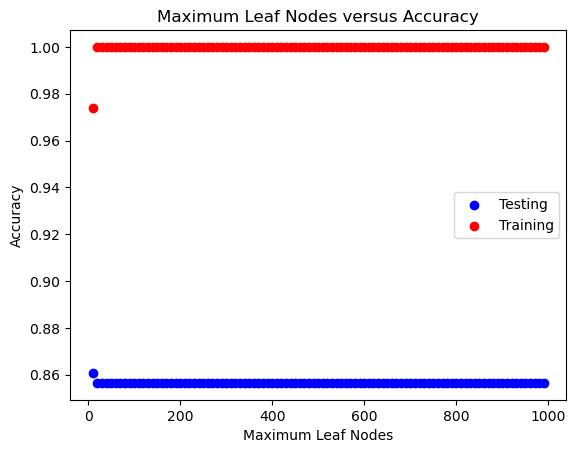

  8%|▊         | 2/25 [00:00<00:03,  6.66it/s]

Score differences: 0.08104145601617796 at 10, training acc: 0.9593023255813954 and testing acc: 0.8782608695652174
Score differences: 0.09701718907987866 at 20, training acc: 0.9709302325581395 and testing acc: 0.8739130434782608


 16%|█▌        | 4/25 [00:00<00:03,  6.89it/s]

Score differences: 0.10860717896865513 at 30, training acc: 0.9694767441860465 and testing acc: 0.8608695652173913
Score differences: 0.10281850353892819 at 40, training acc: 0.9723837209302325 and testing acc: 0.8695652173913043


 24%|██▍       | 6/25 [00:00<00:02,  6.85it/s]

Score differences: 0.10571284125379166 at 50, training acc: 0.9709302325581395 and testing acc: 0.8652173913043478
Score differences: 0.10281850353892819 at 60, training acc: 0.9723837209302325 and testing acc: 0.8695652173913043


 32%|███▏      | 8/25 [00:01<00:02,  6.38it/s]

Score differences: 0.11007330637007073 at 70, training acc: 0.9752906976744186 and testing acc: 0.8652173913043478
Score differences: 0.10716632962588468 at 80, training acc: 0.9723837209302325 and testing acc: 0.8652173913043478


 40%|████      | 10/25 [00:01<00:02,  6.60it/s]

Score differences: 0.10861981799797771 at 90, training acc: 0.9738372093023255 and testing acc: 0.8652173913043478
Score differences: 0.11586198179979768 at 100, training acc: 0.9723837209302325 and testing acc: 0.8565217391304348


 48%|████▊     | 12/25 [00:01<00:01,  6.67it/s]

Score differences: 0.10717896865520726 at 110, training acc: 0.9767441860465116 and testing acc: 0.8695652173913043
Score differences: 0.1231294236602628 at 120, training acc: 0.9796511627906976 and testing acc: 0.8565217391304348


 56%|█████▌    | 14/25 [00:02<00:01,  6.72it/s]

Score differences: 0.09701718907987866 at 130, training acc: 0.9709302325581395 and testing acc: 0.8739130434782608
Score differences: 0.10717896865520726 at 140, training acc: 0.9767441860465116 and testing acc: 0.8695652173913043


 64%|██████▍   | 16/25 [00:02<00:01,  6.75it/s]

Score differences: 0.1129676440849342 at 150, training acc: 0.9738372093023255 and testing acc: 0.8608695652173913
Score differences: 0.11442113245702723 at 160, training acc: 0.9752906976744186 and testing acc: 0.8608695652173913


 72%|███████▏  | 18/25 [00:02<00:01,  6.61it/s]

Score differences: 0.1129676440849342 at 170, training acc: 0.9738372093023255 and testing acc: 0.8608695652173913
Score differences: 0.11152679474216376 at 180, training acc: 0.9767441860465116 and testing acc: 0.8652173913043478


 80%|████████  | 20/25 [00:03<00:00,  6.34it/s]

Score differences: 0.1129676440849342 at 190, training acc: 0.9738372093023255 and testing acc: 0.8608695652173913
Score differences: 0.12167593528816978 at 200, training acc: 0.9781976744186046 and testing acc: 0.8565217391304348


 88%|████████▊ | 22/25 [00:03<00:00,  6.53it/s]

Score differences: 0.1129676440849342 at 210, training acc: 0.9738372093023255 and testing acc: 0.8608695652173913
Score differences: 0.1129676440849342 at 220, training acc: 0.9738372093023255 and testing acc: 0.8608695652173913


 96%|█████████▌| 24/25 [00:03<00:00,  6.63it/s]

Score differences: 0.1129676440849342 at 230, training acc: 0.9738372093023255 and testing acc: 0.8608695652173913
Score differences: 0.1129676440849342 at 240, training acc: 0.9738372093023255 and testing acc: 0.8608695652173913


100%|██████████| 25/25 [00:03<00:00,  6.62it/s]


Score differences: 0.1129676440849342 at 250, training acc: 0.9738372093023255 and testing acc: 0.8608695652173913


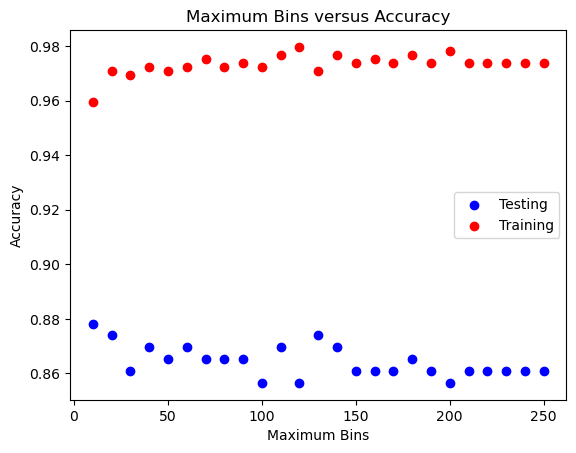

In [41]:


changed_parameter = []
training_scores = []
testing_scores = []



for n_est in tqdm(range(10, 1000, 10)):
        classy = HistGradientBoostingClassifier(max_leaf_nodes=n_est)
        changed_parameter.append(int(n_est))
        classy.fit(x_train_scaled, y_train)
        testing_scores.append(classy.score(x_test_scaled, y_test))
        training_scores.append(classy.score(x_train_scaled, y_train))
        print(f"Score differences: {training_scores[-1] - testing_scores[-1]} at {int(n_est)}, training acc: {training_scores[-1]} and testing acc: {testing_scores[-1]}")


        
fig, ax = plt.subplots()
ax.scatter(changed_parameter, testing_scores, c="blue", label="Testing")
ax.scatter(changed_parameter, training_scores, c="red", label="Training")
ax.legend()
X_text = "Maximum Leaf Nodes"
plt.title(f"{X_text} versus Accuracy")
plt.xlabel(X_text)
plt.ylabel("Accuracy")
plt.show()



changed_parameter = []
training_scores = []
testing_scores = []



for split in tqdm(range(10, 255, 10)):
        classy = HistGradientBoostingClassifier(max_leaf_nodes=10, max_bins=split)
        changed_parameter.append(split)
        classy.fit(x_train_scaled, y_train)
        testing_scores.append(classy.score(x_test_scaled, y_test))
        training_scores.append(classy.score(x_train_scaled, y_train))
        print(f"Score differences: {training_scores[-1] - testing_scores[-1]} at {split}, training acc: {training_scores[-1]} and testing acc: {testing_scores[-1]}")


        
fig, ax = plt.subplots()
ax.scatter(changed_parameter, testing_scores, c="blue", label="Testing")
ax.scatter(changed_parameter, training_scores, c="red", label="Training")
ax.legend()
X_text = "Maximum Bins"
plt.title(f"{X_text} versus Accuracy")
plt.xlabel(X_text)
plt.ylabel("Accuracy")
plt.show()



In [52]:

data = {}
data['minimum_sample_split'] = []
data['n_estimators'] = []
data['minimum_sample_leaf'] = []
data['minimum_impurity_decrease'] = []
data['training_accuracy'] = []
data['testing_accuracy'] = []
data['accuracy_differences'] = []



#The graphs above confirm that the RandomForestClassifier has the best performance, therefore 
# find the combination of parameters that produce each training and testing scores and save it to a csv.
for n_est in tqdm(range(30, 70, 2)):
        for min_split in range(3, 21, 2):
                for min_leaf in np.arange(0.01, 1, 0.05):
                        for impure in np.arange(0.0, 0.11, 0.05):
                                classy = RandomForestClassifier(n_estimators=n_est, min_samples_split=min_split, 
                                                                min_samples_leaf=min_leaf, min_impurity_decrease=impure)
                                classy.fit(x_train_scaled, y_train)
                                train_score = classy.score(x_train_scaled, y_train)
                                test_score = classy.score(x_test_scaled, y_test)
                                data['testing_accuracy'].append(test_score)
                                data['training_accuracy'].append(train_score)
                                data['minimum_sample_split'].append(min_split)
                                data['minimum_sample_leaf'].append(min_leaf)
                                data['minimum_impurity_decrease'].append(impure)
                                data['n_estimators'].append(int(n_est))
                                data['accuracy_differences'].append(abs(train_score-test_score))
                                
data = pd.DataFrame(data)
data.to_csv("RandomForestResults.csv")




100%|██████████| 20/20 [14:25<00:00, 43.27s/it]
